In [1]:
#Libraries
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
from scipy.linalg import svd
import matplotlib.pyplot as plt


## Load and inspect data

In [2]:
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity = pd.read_csv('activity_train.csv', names=column_headers)

column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity_validation = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')


In [3]:
df_activity

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL207881,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [4]:
# check if how many molecules activate on the same protein
df_activity.groupby('Uniprot_IDs')['ChEMBL_IDs'].nunique().sort_values(ascending=False)

Uniprot_IDs
P14416    8045
P29274    5578
P35462    5106
P30542    4812
P08908    4741
          ... 
Q8TDV5      48
P43220      48
Q96RJ0      44
P30550      44
P47211      40
Name: ChEMBL_IDs, Length: 144, dtype: int64

In [5]:
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [6]:
# check how many molecules in the test set are not in the training set
df_activity_validation[~df_activity_validation['ChEMBL_IDs'].isin(df_activity['ChEMBL_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [7]:
# check how many proteins in the test set are not in the training set
df_activity_validation[~df_activity_validation['Uniprot_IDs'].isin(df_activity['Uniprot_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [8]:
# print how many unique proteins and molecules are in the training set
print('Number of unique proteins in the training set:', df_activity['Uniprot_IDs'].nunique())
print('Number of unique molecules in the training set:', df_activity['ChEMBL_IDs'].nunique())

Number of unique proteins in the training set: 144
Number of unique molecules in the training set: 72631


In [9]:
# Get molecule information/non-latent features
mol_bits = pd.read_pickle('mol_bits.pkl')

#Create a sparse matrix with the mol_bits dataset and generate a subset for initial analysis

def create_sparse_matrix(data, num_rows):
    random.seed(42)  # Set a seed for reproducibility
    sampled_indices = random.sample(range(len(data)), num_rows)
    ChEMBL_IDs = [list(data.keys())[i] for i in sampled_indices]
    structural_features = [list(data.values())[i] for i in sampled_indices]

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(num_rows, num_features))
    
    return sparse_matrix, ChEMBL_IDs

sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits, len(mol_bits))
dense_matrix = sparse_matrix.toarray()

df_mol_bits = pd.DataFrame(dense_matrix, index=ChEMBL_IDs)
df_mol_bits

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL4586090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL292574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL3977929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL473197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL243694,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL146720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2113198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL552506,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL301416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# 1. Step: Create user X items (molecules X proteins) matrix

# Define function
def create_interaction_matrix(df, molecule_col, protein_col, activity_col):
    interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')
    interactions = interactions.fillna(0)
    return interactions

# Create the interaction matrix
interactions = create_interaction_matrix(df_activity, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')

# create the interaction matrix
interactions

Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Use a mask to hide the test set from the training set when training the model
def train_test_split_square(interactions, test_ratio=0.2):
    # Determine the size of the test set
    num_molecules, num_proteins = interactions.shape
    rows_cols_remove = int(test_ratio * num_proteins)
    print(f"Removing {rows_cols_remove} rows and columns from the bottom-right corner of the matrix for testing.")
    
    # Create train and test masks
    train_mask = np.ones(interactions.shape)
    test_mask = np.zeros(interactions.shape)
    
    # Indices for the test set (bottom-right corner)
    test_proteins_indices = range(num_proteins - rows_cols_remove, num_proteins)
    test_molecules_indices = range(num_molecules - rows_cols_remove, num_molecules)
    
    # Set the mask values
    for i in test_molecules_indices:
        for j in test_proteins_indices:
            train_mask[i, j] = 0
            test_mask[i, j] = 1
    
    # Apply the masks
    interaction_matrix = interactions.to_numpy()
    train_matrix = interaction_matrix * train_mask
    test_matrix = interaction_matrix * test_mask
    
    return train_matrix, test_matrix, train_mask, test_mask, interactions.index, interactions.columns

# Perform the train-test split
train_matrix, test_matrix, train_mask, test_mask, user_index, item_columns = train_test_split_square(interactions, test_ratio=0.5)

# Convert matrices back to DataFrames for easier handling
train_df = pd.DataFrame(train_matrix, index=user_index, columns=item_columns)
test_df = pd.DataFrame(test_matrix, index=user_index, columns=item_columns)

# Print the shapes to verify
print(f"Train matrix shape: {train_df.shape}")
print(f"Test matrix shape: {test_df.shape}")

train_df

Removing 72 rows and columns from the bottom-right corner of the matrix for testing.
Train matrix shape: (72631, 144)
Test matrix shape: (72631, 144)


Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# just quickly check the masks -> working
print("Train Mask:")
display(train_mask)
print("Test Mask:")
display(test_mask)

Train Mask:


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Test Mask:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [16]:
# 2. Step: Apply SVD
U, sigma, Vt = svd(train_matrix, full_matrices=False)
U.shape

(72631, 144)

In [17]:
Vt.shape

(144, 144)

In [30]:
def make_init_PQ(U, S, Vt, k):
    Uk = U[:, :k]  # Users x latent factors
    Sk = S[:k]
    Vk = Vt[:k, :]  # Latent factors x items
    P = Uk.copy()  # User matrix
    Q = (Sk * Vk.T).T  # Item matrix
    return P, Q

k = 2
P, Q = make_init_PQ(U, sigma, Vt, k)

# Print the shapes of P and Q to verify
print(f"P shape: {P.shape}")
print(f"Q shape: {Q.shape}")

P shape: (72631, 2)
Q shape: (2, 144)


In [31]:
# Function to create a mask for the observed ratings
def create_mask(matrix):
    return 1 * (matrix > 0)

# Function to calculate error using the precomputed mask and its sum
def calc_error(R, P, Q, mask, mask_sum):
    error = (R - np.dot(P, Q)) * mask
    return np.sum(error**2) / mask_sum

# Example usage with train and test matrices
train_mask = create_mask(train_matrix)
test_mask = create_mask(test_matrix)

train_mask_sum = np.sum(train_mask)
test_mask_sum = np.sum(test_mask)

# Calculate training error
train_error = calc_error(train_matrix, P, Q, train_mask, train_mask_sum)
print(f"Training MSE: {train_error}")

# Calculate test error
test_error = calc_error(test_matrix, P, Q, test_mask, test_mask_sum)
print(f"Test MSE: {test_error}")

Training MSE: 24.260550679763565
Test MSE: 22.58331038925929


In [24]:
# Regularized stochastic gradient descent
def run_epoch_reg(elems, R, P, Q, LR, Lp=1, Lq=1):
    random.shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        delta = 2 * (r_ui - P[u, :] @ Q[:, i])
        P[u, :] += LR * (delta * Q[:, i] - Lp * P[u, :])
        Q[:, i] += LR * (delta * P[u, :] - Lq * Q[:, i])
    return P, Q

#we update our RecSys function with the Lambdas for the regularization
def RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, Lp=1, Lq=1, output_mses=False):
    # Initialization
    MSEs=[]
    U, S, V = svd(R, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    rated_elements = [(u,i) for u, i in np.argwhere(R>0)]

    # Run all the epochs
    for i in range(num_epochs):
        P, Q = run_epoch_reg(rated_elements, R, P, Q, LR, Lp, Lq)
        mse = calc_error(R, P, Q, train_mask, train_mask_sum)
        MSEs.append(mse)
        
    if output_mses==False: return P,Q
    else: return P,Q, MSEs

P,Q, mses = RecSys_SGD(train_matrix, num_epochs=100, k=2, LR=0.001, output_mses=True)
print("The MSE is:", calc_error(train_matrix, P, Q, train_mask, train_mask_sum))
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)

/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_15376/1292611130.py:7: RuntimeWarning: overflow encountered in multiply
  P[u, :] = P[u, :] + LR * (delta * Q[:, i] - Lp * P[u, :])
/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_15376/1292611130.py:8: RuntimeWarning: invalid value encountered in subtract
  Q[:, i] = Q[:, i] + LR * (delta * P[u, :] - Lq * Q[:, i])
/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_15376/1292611130.py:8: RuntimeWarning: overflow encountered in multiply
  Q[:, i] = Q[:, i] + LR * (delta * P[u, :] - Lq * Q[:, i])
/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_15376/1292611130.py:6: RuntimeWarning: invalid value encountered in matmul
  delta = 2 * (r_ui - P[u, :] @ Q[:, i])
/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_15376/1337605041.py:7: RuntimeWarning: invalid value encountered in multiply
  error = (R - np.dot(P, Q)) * mask


The MSE is: nan
P factor
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [ 0.  0.]
 [ 0.  0.]
 [nan nan]]
Q factor
[[       nan        nan        nan        nan        nan  1.752e-08
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan  8.650e-19        nan        nan
   4.475e-21        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
  -2.411e-17 -2.306e-16        nan        nan        nan        nan
         nan  2.428e-19        nan -1.805e-16        nan        nan
         nan        nan        nan        nan  2.535e-19        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         n

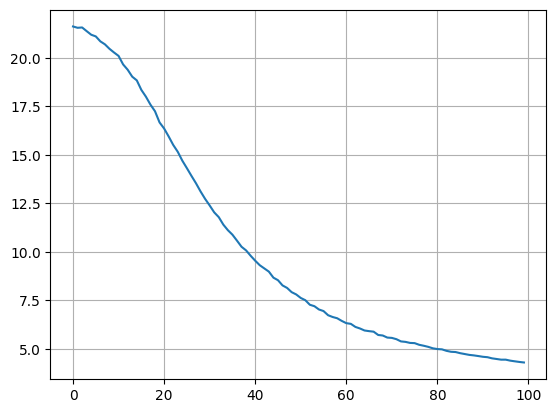

In [ ]:
plt.plot(mses)
plt.grid()
plt.show()

In [30]:
# prepare molecule fingerprints
desired_order = interactions.columns
df_mol_bits_reindexed = df_mol_bits.reindex(desired_order)
df_mol_bits_reindexed

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100045,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL99983,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
CHEMBL99987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
molecule_features = df_mol_bits_reindexed.to_numpy()
molecule_features.shape

(72631, 2048)

In [35]:
# test adding the molecule features
def make_init_PQ(U, S, V, k, user_features):
    Uk = U[:, :k] 
    Sk = S[:k]
    Vk = V[:k, :]
    Q = Uk.copy() 
    P = (Sk * Vk.T).transpose()
    
    # Concatenate user features to Q (since Q is user matrix now)
    Q = np.hstack((Q, user_features))
    
    return P, Q


(2058, 72631)

In [34]:
# test adding the molecule features to !
# Initialize P and Q with SVD
U, S, V = svd(train_matrix, full_matrices=False)
P, Q = make_init_PQ(U, S, V, k)

# Concatenate the user-specific features with the initialized Q
Q_augmented = np.concatenate((Q, molecule_features.T), axis=0)
Q_augmented.shape

def run_epoch_reg_with_augmented_Q(elems, R, P, Q_augmented, LR, Lp=1, Lq=1):
    random.shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        if r_ui > 0:  # Only update for non-zero ratings
            delta = 2 * (r_ui - P[:, i] @ Q_augmented[:, u])
            Q_augmented[:, u] = Q_augmented[:, u] + LR * (delta * P[:, i] - Lq * Q_augmented[:, u])
            P[:, i] = P[:, i] + LR * (delta * Q_augmented[:, u] - Lp * P[:, i])
    return P, Q_augmented

def RecSys_SGD_with_augmented_Q(R, user_features, num_epochs=100, k=2, LR=0.01, Lp=1, Lq=1, output_mses=False):
    MSEs = []
    U, S, V = svd(R, full_matrices=False)
    P, Q = make_init_PQ(U, S, V, k)
    Q_augmented = np.concatenate((Q, user_features.T), axis=0)  # Concatenate user features
    rated_elements = [(u, i) for u, i in np.argwhere(R > 0)]
    
    for epoch in range(num_epochs):
        P, Q_augmented = run_epoch_reg_with_augmented_Q(rated_elements, R, P, Q_augmented, LR, Lp, Lq)
        mse = calc_error(R, P, Q_augmented, train_mask, train_mask_sum)
        MSEs.append(mse)
    if output_mses == False:
        return P, Q_augmented
    else:
        return P, Q_augmented, MSEs

# Run the updated RecSys function with augmented Q
P, Q_augmented, mses = RecSys_SGD_with_augmented_Q(train_matrix, molecule_features, num_epochs=50, k=2, LR=0.001, output_mses=True)
print("The MSE is:", calc_error(train_matrix, P, Q_augmented, train_mask, train_mask_sum))
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q_augmented factor")
    print(Q_augmented)


IndexError: index 55545 is out of bounds for axis 1 with size 2

In [ ]:
plt.plot(mses)
plt.grid()
plt.show()

In [ ]:
# @TODO: Hyperparameter tuning -> see TP10 for inspiration
# @TODO: Implement the prediction function

## OLD code snippets

In [41]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

def create_sparse_interaction_matrix(df, molecule_col, protein_col, activity_col, row_entity='molecule'):
    # Validate input for row_entity
    if row_entity not in ['molecule', 'protein']:
        raise ValueError("row_entity must be either 'molecule' or 'protein'")
    
    # Determine indices based on row entity
    if row_entity == 'molecule':
        row_ids, row_indices = np.unique(df[molecule_col], return_inverse=True)
        col_ids, col_indices = np.unique(df[protein_col], return_inverse=True)
        row_label, col_label = molecule_col, protein_col
    else:
        row_ids, row_indices = np.unique(df[protein_col], return_inverse=True)
        col_ids, col_indices = np.unique(df[molecule_col], return_inverse=True)
        row_label, col_label = protein_col, molecule_col

    # Create a sparse matrix
    shape = (len(row_ids), len(col_ids))
    interaction_matrix = csr_matrix((df[activity_col], (row_indices, col_indices)), shape=shape)

    # Print what is presented in rows and what in columns
    print(f"Rows represent {row_entity}, meaning we are working in {row_entity}-{row_entity} similarity space.")

    return interaction_matrix, row_ids, col_ids

def cosine_similarity_sparse(matrix):
    # Normalize the matrix rows to have zero mean and norm 1
    matrix_normalized = normalize(matrix, norm='l2', axis=1)
    # Compute the cosine similarity matrix
    similarity_matrix = matrix_normalized.dot(matrix_normalized.T)

    return similarity_matrix

# Create interaction matrix
interaction_matrix, molecule_ids, protein_ids = create_sparse_interaction_matrix(activity_train, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')
print("Sparse Interaction Matrix (preview):\n", interaction_matrix[:10, :10].toarray())

# Compute cosine similarities
similarity_matrix = cosine_similarity_sparse(interaction_matrix)
print("Cosine Similarity Matrix (preview):\n", similarity_matrix[:5, :5].toarray())

Rows represent molecule, meaning we are working in molecule-molecule similarity space.
Sparse Interaction Matrix (preview):
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Cosine Similarity Matrix (preview):
 [[1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.67350445]
 [0.         0.         0.         0.67350445 1.        ]]


In [42]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

def create_sparse_interaction_matrix(df, molecule_col, protein_col, activity_col, row_entity='molecule'):
    if row_entity not in ['molecule', 'protein']:
        raise ValueError("row_entity must be either 'molecule' or 'protein'")
    
    if row_entity == 'molecule':
        row_ids, row_indices = np.unique(df[molecule_col], return_inverse=True)
        col_ids, col_indices = np.unique(df[protein_col], return_inverse=True)
    else:
        row_ids, row_indices = np.unique(df[protein_col], return_inverse=True)
        col_ids, col_indices = np.unique(df[molecule_col], return_inverse=True)

    shape = (len(row_ids), len(col_ids))
    interaction_matrix = csr_matrix((df[activity_col], (row_indices, col_indices)), shape=shape)

    print(f"Rows represent {row_entity}s, meaning we are working in {row_entity}-{row_entity} similarity space.")
    return interaction_matrix, row_ids, col_ids

def cosine_similarity_sparse(matrix):
    normalized_matrix = normalize(matrix, norm='l2', axis=1)
    similarity_matrix = normalized_matrix.dot(normalized_matrix.T)
    return similarity_matrix

def make_GBAMatrix(df):
    interaction_matrix = df.values
    global_mean = np.nanmean(interaction_matrix)
    column_means = np.nanmean(interaction_matrix, axis=0)
    column_deviation = np.ones(interaction_matrix.shape) * column_means - global_mean

    transposed_matrix = interaction_matrix.T
    row_means = np.nanmean(transposed_matrix, axis=0)
    row_deviation = np.ones(transposed_matrix.shape) * row_means - global_mean
    row_deviation = row_deviation.T

    return global_mean + column_deviation + row_deviation

def estimate_score(interaction_df, similarity_matrix, num_neighbors, molecule_index, protein_index, gba_matrix, verbose=False):
    interaction_values = interaction_df.values
    num_molecules, num_proteins = interaction_values.shape
    molecule_similarities = list(zip(similarity_matrix[molecule_index], range(num_molecules)))
    molecule_similarities.sort(reverse=True)
    
    neighbor_count = 0
    weighted_sum = 0
    similarity_sum = 0
    
    if verbose:
        print(f"Molecule index: {molecule_index}, Protein index: {protein_index}")
    
    for similarity, similar_molecule_index in molecule_similarities[1:]:
        if not np.isnan(interaction_values[similar_molecule_index, protein_index]) and similarity > 0:
            neighbor_count += 1
            weighted_sum += similarity * interaction_values[similar_molecule_index, protein_index]
            similarity_sum += similarity
            if verbose:
                print(f"\tSimilar molecule index: {similar_molecule_index}, Score: {interaction_values[similar_molecule_index, protein_index]:.1f} (Similarity: {similarity:.3f})")
        if neighbor_count >= num_neighbors:
            break
    
    if similarity_sum <= 0:
        if verbose:
            print("\tNo similar molecules found: using the Global Baseline Average")
        return gba_matrix[molecule_index, protein_index]
    
    estimated_score = weighted_sum / similarity_sum
    if verbose:
        print(f"\tEstimated Score: {estimated_score:.4f}")
    
    return estimated_score

def process_and_compute_similarities(df, molecule_col='ChEMBL_IDs', protein_col='Uniprot_IDs', activity_col='Activity', row_entity='molecule', augment_features=None):
    interaction_matrix, row_ids, col_ids = create_sparse_interaction_matrix(df, molecule_col, protein_col, activity_col, row_entity)
    similarity_matrix = cosine_similarity_sparse(interaction_matrix)
    similarity_df = pd.DataFrame(similarity_matrix.toarray(), index=row_ids, columns=row_ids)

    interaction_dense = interaction_matrix.toarray()
    interaction_df = pd.DataFrame(interaction_dense, index=row_ids, columns=col_ids)
    gba_matrix = make_GBAMatrix(interaction_df)
    gba_df = pd.DataFrame(gba_matrix, index=row_ids, columns=col_ids)

    if augment_features is not None:
        feature_similarity = augment_features_similarity(augment_features, row_ids)
        combined_similarity = (similarity_matrix + feature_similarity) / 2
        similarity_df = pd.DataFrame(combined_similarity.toarray(), index=row_ids, columns=row_ids)

    return similarity_df, gba_df

def augment_features_similarity(features_df, row_ids):
    features = features_df.loc[row_ids].values
    norm_features = normalize(features, axis=1)
    similarity_matrix = norm_features.dot(norm_features.T)
    return csr_matrix(similarity_matrix)

def predict_for_test_data(test_df, similarity_df, gba_df, interaction_df, num_neighbors=5):
    predictions = []
    for index, row in test_df.iterrows():
        molecule = row['ChEMBL_IDs']
        protein = row['Uniprot_IDs']
        if molecule in interaction_df.index and protein in interaction_df.columns:
            molecule_index = interaction_df.index.get_loc(molecule)
            protein_index = interaction_df.columns.get_loc(protein)
            estimated_score = estimate_score(interaction_df, similarity_df.to_numpy(), num_neighbors, molecule_index, protein_index, gba_matrix=gba_df.to_numpy())
        else:
            estimated_score = np.nan  # If molecule or protein is not in the training data, we cannot predict
        predictions.append(estimated_score)
    return predictions

# Example usage
# Assuming `activity_train` is your training DataFrame and `activity_test` is your test DataFrame
similarity_df, gba_df = process_and_compute_similarities(activity_train, molecule_col='ChEMBL_IDs', protein_col='Uniprot_IDs', activity_col='Activity', row_entity='molecule')

# Convert interaction_matrix to DataFrame for compatibility with estimate_score
interaction_matrix, molecule_ids, protein_ids = create_sparse_interaction_matrix(activity_train, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')
interaction_dense = interaction_matrix.toarray()
interaction_df = pd.DataFrame(interaction_dense, index=molecule_ids, columns=protein_ids)

predictions = predict_for_test_data(activity_test, similarity_df, gba_df, interaction_df)

# Add predictions to the test DataFrame
activity_test['Predicted_Activity'] = predictions
print(activity_test)


Rows represent molecule, meaning we are working in molecule-molecule similarity space.
Rows represent molecule, meaning we are working in molecule-molecule similarity space.
       Uniprot_IDs     ChEMBL_IDs  Activity  Predicted_Activity
111427      P43115  CHEMBL1272136         8                 NaN
70017       P30989  CHEMBL4740987         1            0.000000
123263      Q13258   CHEMBL192729         1            0.599546
23377       P14416   CHEMBL593897         3            0.391769
132000      Q9Y5N1   CHEMBL453878         7                 NaN
...            ...            ...       ...                 ...
102104      P41143  CHEMBL3698868         2            0.000000
79864       P34972  CHEMBL3410826        10                 NaN
54380       P29274   CHEMBL223456         1            0.000000
91789       P35372  CHEMBL4463703         6                 NaN
27231       P14416  CHEMBL4742056         5            0.000000

[27143 rows x 4 columns]


In [ ]:
# Function to estimate scores (based on TP function)
def estimate_score(interaction_df, similarity_matrix, num_neighbors, molecule_index, protein_index, gba_matrix, verbose=False):
    interaction_values = interaction_df.values
    num_molecules, num_proteins = interaction_values.shape
    molecule_similarities = list(zip(similarity_matrix[molecule_index], range(num_molecules)))
    molecule_similarities.sort(reverse=True)
    
    neighbor_count = 0
    weighted_sum = 0
    similarity_sum = 0
    
    if verbose:
        print(f"Molecule index: {molecule_index}, Protein index: {protein_index}")
    
    for similarity, similar_molecule_index in molecule_similarities[1:]:
        if not np.isnan(interaction_values[similar_molecule_index, protein_index]) and similarity > 0:
            neighbor_count += 1
            weighted_sum += similarity * interaction_values[similar_molecule_index, protein_index]
            similarity_sum += similarity
            if verbose:
                print(f"\tSimilar molecule index: {similar_molecule_index}, Score: {interaction_values[similar_molecule_index, protein_index]:.1f} (Similarity: {similarity:.3f})")
        if neighbor_count >= num_neighbors:
            break
    
    if similarity_sum <= 0:
        if verbose:
            print("\tNo similar molecules found: using the Global Baseline Average")
        return gba_matrix[molecule_index, protein_index]
    
    estimated_score = weighted_sum / similarity_sum
    if verbose:
        print(f"\tEstimated Score: {estimated_score:.4f}")
    
    return estimated_score

In [33]:
import numpy as np

def predict_interaction_average(test_df, train_interaction_matrix, similarity_matrix, molecule_ids, protein_ids):
    """
    Predicts the interaction using a simple average of known interactions of similar molecules.
    The prediction is rounded to the nearest integer and constrained between 1 and 10.
    
    Args:
    test_df (DataFrame): The test dataset containing molecule and protein pairs.
    train_interaction_matrix (csr_matrix): The interaction matrix from the training data.
    similarity_matrix (array): The precomputed cosine similarity matrix between molecules.
    molecule_ids (array): The list of molecule IDs corresponding to the indices in the interaction matrix.
    protein_ids (array): The list of protein IDs corresponding to the indices in the interaction matrix.
    
    Returns:
    DataFrame: A DataFrame with all columns from test_df and the predicted interactions.
    """
    results = test_df.copy()
    predicted_activities = []
    
    for index, row in test_df.iterrows():
        molecule = row['ChEMBL_IDs']
        protein = row['Uniprot_IDs']
        
        if molecule in molecule_ids and protein in protein_ids:
            molecule_index = np.where(molecule_ids == molecule)[0][0]
            protein_index = np.where(protein_ids == protein)[0][0]
            
            # Get the similarity scores for this molecule against all others
            similarity_scores = similarity_matrix[molecule_index, :]
            
            # Get the known interactions for the target protein
            protein_interactions = train_interaction_matrix[:, protein_index].toarray().flatten()
            
            # Consider only molecules with known interactions
            known_interactions = protein_interactions[protein_interactions != 0]
            if len(known_interactions) > 0:
                predicted_interaction = np.round(known_interactions.mean())
            else:
                predicted_interaction = 0  # No known interactions to average
        else:
            predicted_interaction = 0  # Molecule or protein not found in training set

        # Clamp the predicted interaction between 1 and 10
        if predicted_interaction < 1 and predicted_interaction > 0:
            predicted_interaction = 1
        elif predicted_interaction > 10:
            predicted_interaction = 10
        elif predicted_interaction <= 0:
            predicted_interaction = 0
        
        predicted_activities.append(predicted_interaction)
    
    results['Predicted_Activity'] = predicted_activities
    return results


# Predict interactions
predictions_average = predict_interaction_average(activity_test, interaction_matrix, similarity_matrix, molecule_ids, protein_ids)
predictions_average

,Uniprot_IDs,ChEMBL_IDs,Activity,Predicted_Activity
111427,P43115,CHEMBL1272136,8,0.0
70017,P30989,CHEMBL4740987,1,5.0
123263,Q13258,CHEMBL192729,1,4.0
23377,P14416,CHEMBL593897,3,4.0
132000,Q9Y5N1,CHEMBL453878,7,0.0
...,...,...,...,...
102104,P41143,CHEMBL3698868,2,4.0
79864,P34972,CHEMBL3410826,10,0.0
54380,P29274,CHEMBL223456,1,4.0
91789,P35372,CHEMBL4463703,6,0.0


In [34]:
# Check how many predictions are == 0
predictions_average[predictions_average['Predicted_Activity'] == 0]

,Uniprot_IDs,ChEMBL_IDs,Activity,Predicted_Activity
111427,P43115,CHEMBL1272136,8,0.0
132000,Q9Y5N1,CHEMBL453878,7,0.0
103440,P41145,CHEMBL426084,10,0.0
72361,P32245,CHEMBL258245,6,0.0
120339,P50406,CHEMBL4162914,4,0.0
...,...,...,...,...
33875,P21554,CHEMBL3323674,7,0.0
31475,P21554,CHEMBL109393,9,0.0
111034,P43088,CHEMBL37853,6,0.0
79864,P34972,CHEMBL3410826,10,0.0


In [36]:
# Calculate RMSE for those that have a prediction
from sklearn.metrics import mean_squared_error

predictions_average_filtered = predictions_average[predictions_average['Predicted_Activity'] != 0]
rmse = np.sqrt(mean_squared_error(predictions_average_filtered['Activity'], predictions_average_filtered['Predicted_Activity']))
print('RMSE (average):', rmse)

RMSE (average): 2.7366858729555097


In [38]:
def predict_interaction_weighted(test_df, train_interaction_matrix, similarity_matrix, molecule_ids, protein_ids):
    """
    Predicts the interaction using a weighted average of known interactions of similar molecules, weighted by similarity scores.
    The prediction is rounded to the nearest integer and constrained between 1 and 10.
    
    Args:
    test_df (DataFrame): The test dataset containing molecule and protein pairs.
    train_interaction_matrix (csr_matrix): The interaction matrix from the training data.
    similarity_matrix (array): The precomputed cosine similarity matrix between molecules.
    molecule_ids (array): The list of molecule IDs corresponding to the indices in the interaction matrix.
    protein_ids (array): The list of protein IDs corresponding to the indices in the interaction matrix.
    
    Returns:
    DataFrame: A DataFrame with all columns from test_df and the predicted interactions.
    """
    results = test_df.copy()
    predicted_activities = []
    
    for index, row in test_df.iterrows():
        molecule = row['ChEMBL_IDs']
        protein = row['Uniprot_IDs']
        
        if molecule in molecule_ids and protein in protein_ids:
            molecule_index = np.where(molecule_ids == molecule)[0][0]
            protein_index = np.where(protein_ids == protein)[0][0]
            
            # Get the similarity scores for this molecule against all others
            similarity_scores = similarity_matrix[molecule_index, :]
            
            # Get the known interactions for the target protein
            protein_interactions = train_interaction_matrix[:, protein_index].toarray().flatten()
            
            # Calculate the weighted average using similarities as weights
            if np.any(protein_interactions != 0):
                weighted_sum = np.dot(similarity_scores, protein_interactions)
                sum_of_weights = similarity_scores.sum()
                predicted_interaction = np.round(weighted_sum / sum_of_weights) if sum_of_weights != 0 else 0
            else:
                predicted_interaction = 0  # No interactions to weigh
        else:
            predicted_interaction = 0  # Molecule or protein not found in training set

        # Clamp the predicted interaction between 1 and 10
        predicted_interaction = int(max(1, min(predicted_interaction, 10)) if predicted_interaction > 0 else 0)
    
        predicted_activities.append(predicted_interaction)
    
    results['Predicted_Activity'] = predicted_activities
    return results


# Predict interactions
predictions_weighted = predict_interaction_weighted(activity_test, interaction_matrix, similarity_matrix, molecule_ids, protein_ids)
predictions_weighted

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [ ]:
# Check how many predictions are == 0
predictions_weighted[predictions_weighted['Predicted_Activity'] == 0]

,Uniprot_IDs,ChEMBL_IDs,Activity,Predicted_Activity


In [ ]:
# Calculate RMSE
predictions_weighted_filtered = predictions_weighted[predictions_weighted['Predicted_Activity'] != 0]
rmse = np.sqrt(mean_squared_error(predictions_weighted_filtered['Activity'], predictions_weighted_filtered['Predicted_Activity']))
print('RMSE (weighted):', rmse)


RMSE (weighted): 3.7599614098594967
